In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
from scipy.stats import norm
from os import path
import re

import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
matplotlib.rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def remove_bg(counts):
    """Removes background noise for 1minute data"""
    bg_file = "/Users/jan/Documents/References/Classes/Spring_2020/Physics_111B/gammaray_spectroscopy/8-6/background_1min.csv"
    
    bg = genfromtxt(bg_file, delimiter=',', skip_header=1, usecols=(1))
    
    if len(bg) > len(counts):
        print("here")
        arr = bg[:len(counts)].copy()
    elif len(bg) < len(counts):
        print("now here")
        arr = np.pad(bg, (0, bg.shape-counts.shape), 'constant')
    else:
        return counts - bg
    return counts - arr

def linear_calib(x):
    """Linear calibration for channels form PHA to energies in MeV"""
    return -0.02942735 + 0.4521013 *x

In [3]:
from numpy import genfromtxt

def from_pha_data(filename):
    """Exports data from Pulse Height analyzer. Note only channel 0 is active."""
    
    col0 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0))
    col1 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(1))
    
    # for safe measure
    col0 = col0[~np.isnan(col0)]
    col1 = col1[~np.isnan(col1)]
    return col0, col1

def find_peaks(energies, counts):
    """
    Determines the first and second peak by first finding this highest peak. Then give the index
    where the derivative changes signs and determines next peak in index range. Ignore second peak
    if source does not contain second peak.
    
    """
    
    peak1_idx = np.argmax(counts)
    peak1 = energies[peak1_idx]
    
    holder = np.max(counts)
    
    gap_idx1 = 0
    gap_idx2 = 0
    
    for i, val in reversed(list(enumerate(counts[:peak1_idx-5]))):
        if (holder < val):
            gap_idx1 = i
            break
        holder = val

    holder = np.max(counts)
    
    for i, val in enumerate(counts[peak1_idx+5:]):
        if (holder < val):
            gap_idx2 = i
            break
        holder = val
        
    peak2_count = [np.max(counts[peak1_idx+gap_idx2:])]
    peak2_idxs = zip(*np.where(counts == peak2_count))
    
    peak2_idxs = np.array(list(peak2_idxs)).flatten()
    
    for loc in peak2_idxs:
        if energies[loc] > peak1:
            peak2 = energies[loc]
            peak2_idx = loc
    
    #-------------
    gap_idx3 = 0
    gap_idx4 = 0
    
    holder2 = counts[peak2_idx]
    for i, val in reversed(list(enumerate(counts[peak1_idx+gap_idx2+80:peak2_idx]))):
        if (holder < val):
            gap_idx3 = i
            break
        holder2 = val
    
    for i, val in enumerate(counts[peak2_idx+10:]):
        if (holder < val):
            gap_idx4 = i
            break
        holder2 = val
    
    return peak1, peak2, gap_idx1, peak1_idx+gap_idx2, peak2_idx-gap_idx3, peak2_idx+gap_idx4+10

def extract_info(filename):
    col0, col1 = from_pha_data(filename)
    
    col0 = linear_calib(col0)
    col1 = remove_bg(col1)
    
    peak1, peak2, idx1, idx2, idx3, idx4 = find_peaks(col0, col1)
    
    return col0, col1, peak1, peak2, idx1, idx2, idx3, idx4

In [4]:
def gauss_model(x, height, mean, sigma):
    return  height * np.sqrt(2*np.pi) * sigma * norm.pdf(x, mean, sigma)

def fit_sources(channel, counts):
    """
    Fits source to gaussiam curve and returns fitted gaussian parameters.
    
    """
    #err = np.mean(np.diff(channel)) # error in bins
    
    par, cov = fitter.curve_fit(gauss_model, channel, counts, maxfev=15000)
    plt.figure()
    plt.scatter(channel, counts)
    plt.plot(channel, gauss_model(channel, *par))
    plt.show()
    
    return par, cov

In [5]:
import os
files = [f for f in os.listdir('.') if os.path.isfile(f)]
csv_files = [f for f in files if f.endswith('.csv')]

na_csv = [f for f in files if f.startswith('8-9Na22')]
cs_csv = [f for f in files if f.startswith('8-9Cs137')]
print(na_csv, cs_csv)

['8-9Na22_no_abso.csv', '8-9Na22Al-642pm02.csv', '8-9Na22Cu-1525pm01.csv', '8-9Na22Pb-5pt365pm00.csv', '8-9Na22Cu-75pm02.csv', '8-9Na22Cu-75pm01.csv', '8-9Na22Pb-pt51pm00.csv', '8-9Na22Al-83pm02.csv', '8-9Na22Pb-pt52pm00.csv', '8-9Na22Al-80pm02.csv'] ['8-9Cs137Cu-75pm01.csv', '8-9Cs137Cu-75pm02.csv', '8-9Cs137Al-80pm02.csv', '8-9Cs137Pb-pt51pm00.csv', '8-9Cs137_no_abso.csv', '8-9Cs137Al-83pm02.csv', '8-9Cs137Pb-pt52pm00.csv']


(1.784981755264, 2.273196907108, 372, 408, 489, 516)
(1.977698976415, 2.059068168389, 417, 456, 456, 479)


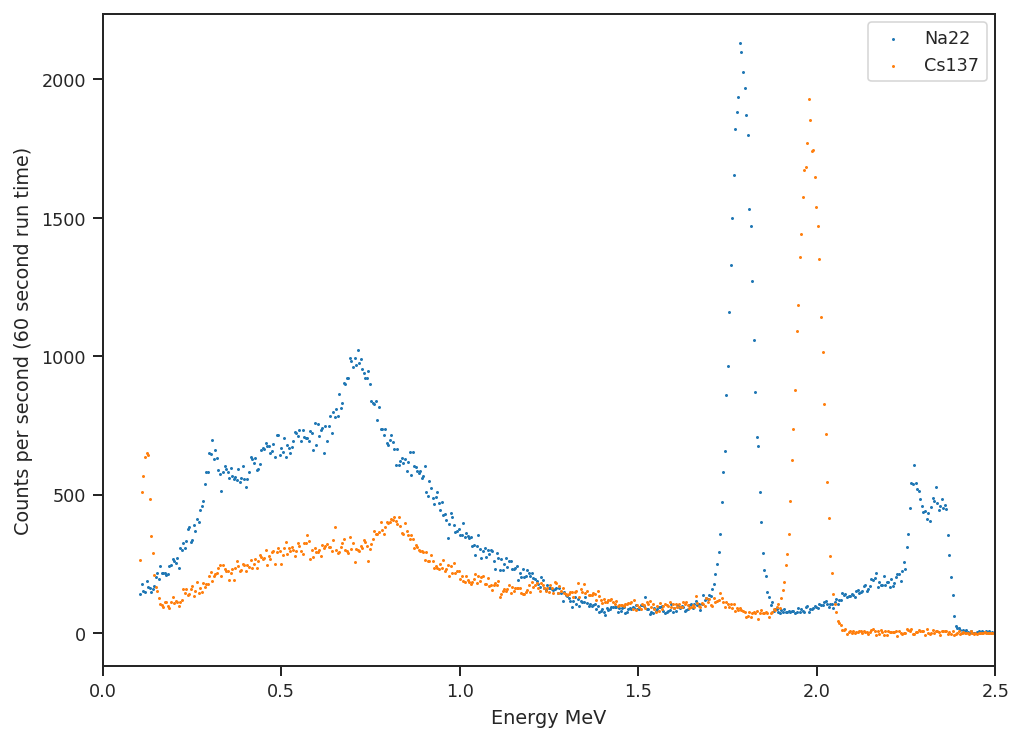

In [6]:
# [no_abso] [Cu: 75pm01 75pm02 1525pm01] [Al: 80pm02 83pm02 642pm02 ] [Pb: 51pm00 52pm00 365pm00] 
na_no_abso = extract_info('8-9_na_rv.csv')
cs_no_abso = extract_info('8-9_cs_rv.csv')
#cs_no_abso = extract_info('8-9Cs137_no_abso.csv')


print(na_no_abso[2:])
print(cs_no_abso[2:])

plt.figure(figsize=(8,6))
plt.scatter(na_no_abso[0], na_no_abso[1], s= 0.5, label='Na22')
plt.scatter(cs_no_abso[0], cs_no_abso[1], s= 0.5, label='Cs137')
plt.xlim(0,2.5)
plt.ylabel("Counts per second (60 second run time)")
plt.xlabel("Energy MeV")
plt.legend()
plt.show()

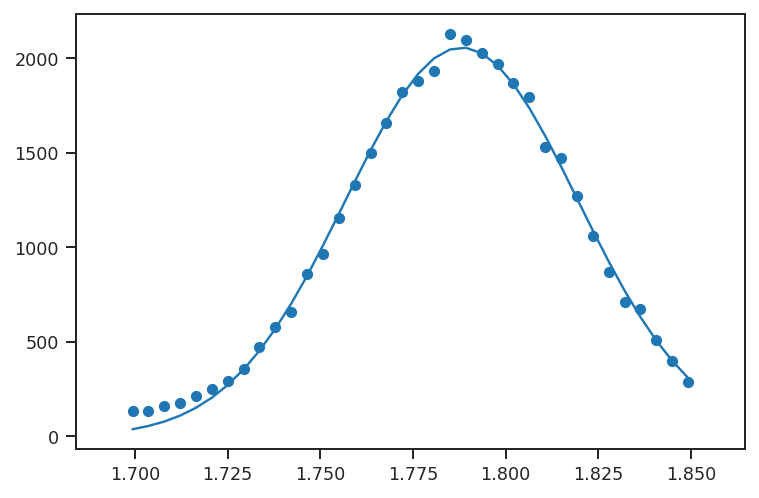

[2057.9176677292144, 16.128403150625093]


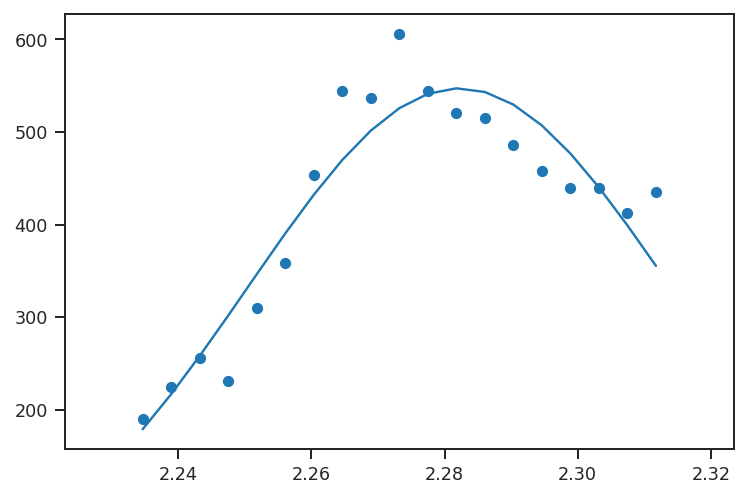

[547.2425347908213, 16.128403150625093]


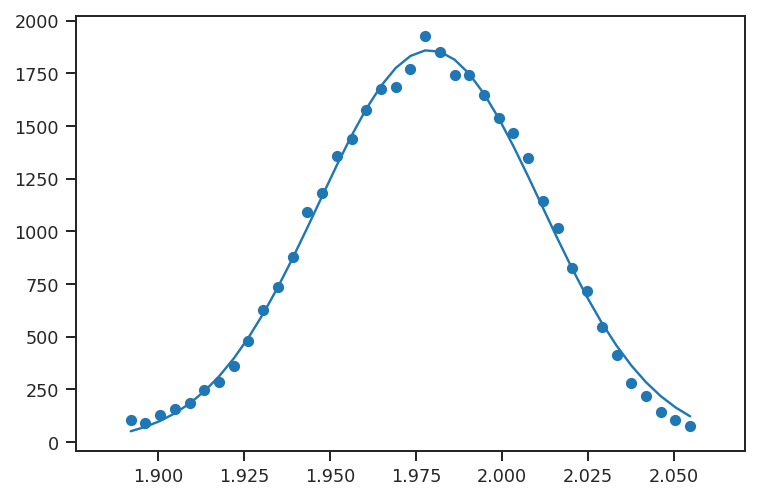

[2116.0623032598214, 12.785207396010447]


In [7]:
# No absorober values are no good. need to remeasure with proper distance

na1_par, na1_cov = fit_sources(na_no_abso[0][na_no_abso[4]:na_no_abso[5]], na_no_abso[1][na_no_abso[4]:na_no_abso[5]])
na1_noabso = [na1_par[0], np.sqrt(np.diag(na1_cov))[0]]
print(na1_noabso)

na2_par, na2_cov = fit_sources(na_no_abso[0][na_no_abso[6]+8:na_no_abso[7]], na_no_abso[1][na_no_abso[6]+8:na_no_abso[7]])
na2_noabso = [na2_par[0], np.sqrt(np.diag(na1_cov))[0]]
print(na2_noabso)

cs1_par, cs1_cov = fit_sources(cs_no_abso[0][cs_no_abso[4]:cs_no_abso[5]], cs_no_abso[1][cs_no_abso[4]:cs_no_abso[5]])
cs1_noabso = [2116.0623032598214, 12.785207396010447]
print(cs1_noabso)

In [8]:
rhos = [8.93, 2.71, 11.34] # density [g/cm^3] of Cu, Al, Pb

# thicknesses converted to centimeters [value, uncertainty]
cu_t = np.array([[0.75, 0.01], [0.75, 0.02], [15.25, 0.01]])*0.1
cu_t = np.insert(cu_t, 0, rhos[0], axis=1)

al_t = np.array([[0.8, 0.02], [0.83, 0.02], [6.42, 0.02]])*0.1
al_t = np.insert(al_t, 0, rhos[1], axis=1)

pb_t = np.array([[0.51, 0], [0.52, 0], [5.365, 0]])*0.1
pb_t = np.insert(pb_t, 0, rhos[2], axis=1)

elem_t = np.array([cu_t, al_t, pb_t])
print(elem_t[0][1])

[8.93e+00 7.50e-02 2.00e-03]


In [9]:
# note: extract_info() gives [energies, counts, peak1, peak2]

na_values = {
    #"No Absorber": extract_info('8-9Na22_no_abso.csv'),
    
    "Cu 0.75 +/- 0.01 mm": [extract_info('8-9Na22Cu-75pm01.csv'), cu_t[0]],
    "Cu 0.75 +/- 0.02 mm": [extract_info('8-9Na22Cu-75pm02.csv'), cu_t[1]],
    "Cu 15.25 +/- 0.01 mm": [extract_info('8-9Na22Cu-1525pm01.csv'), cu_t[2]],
    
    "Al 0.80 +/- 0.02 mm": [extract_info('8-9Na22Al-80pm02.csv'), al_t[0]],
    "Al 0.83 +/- 0.02 mm": [extract_info('8-9Na22Al-83pm02.csv'), al_t[1]],
    "Al 6.42 +/- 0.02 mm": [extract_info('8-9Na22Al-642pm02.csv'), al_t[2]],
        
    "Pb 0.51 mm": [extract_info('8-9Na22Pb-pt51pm00.csv'), pb_t[0]],
    "Pb 0.52 mm": [extract_info('8-9Na22Pb-pt52pm00.csv'), pb_t[1]],
    "Pb 5.365 mm": [extract_info('8-9Na22Pb-5pt365pm00.csv'), pb_t[2]]
}

cs_values = {
    #"No Absorber": extract_info('8-9Cs137_no_abso.csv'),
    
    "Cu 0.75 +/- 0.01 mm": [extract_info('8-9Cs137Cu-75pm01.csv'), cu_t[0]],
    "Cu 0.75 +/- 0.02 mm": [extract_info('8-9Cs137Cu-75pm02.csv'), cu_t[1]],

    "Al 0.80 +/- 0.02 mm": [extract_info('8-9Cs137Al-80pm02.csv'), al_t[0]],
    "Al 0.83 +/- 0.02 mm": [extract_info('8-9Cs137Al-83pm02.csv'), al_t[1]],

    "Pb 0.51 mm": [extract_info('8-9Cs137Pb-pt51pm00.csv'), pb_t[0]],
    "Pb 0.52 mm": [extract_info('8-9Cs137Pb-pt52pm00.csv'), pb_t[1]]
}

display(na_values.keys(), cs_values.keys())
print(extract_info('8-9Na22Cu-75pm01.csv')) # col0, col1, peak1, peak2, idx1, idx2, idx3, idx4

dict_keys(['Cu 0.75 +/- 0.01 mm', 'Cu 0.75 +/- 0.02 mm', 'Cu 15.25 +/- 0.01 mm', 'Al 0.80 +/- 0.02 mm', 'Al 0.83 +/- 0.02 mm', 'Al 6.42 +/- 0.02 mm', 'Pb 0.51 mm', 'Pb 0.52 mm', 'Pb 5.365 mm'])

dict_keys(['Cu 0.75 +/- 0.01 mm', 'Cu 0.75 +/- 0.02 mm', 'Al 0.80 +/- 0.02 mm', 'Al 0.83 +/- 0.02 mm', 'Pb 0.51 mm', 'Pb 0.52 mm'])

(array([0.10620304, 0.1104858 , 0.1147681 , ..., 4.47873693, 4.48301833,
       4.48730425]), array([135., 152., 135., ...,   0.,   0.,   0.]), 1.8149605924669998, 2.268915507797, 379, 417, 498, 515)


In [10]:
def massAtten(I0, I, rho, t):
    I_ratio = I / I0
    print("ratio: ", I_ratio)
    logI = np.log(I_ratio)
    return logI/(rho*t)

def massAtten_error(mac, I0, I0_err, I, I_err, t, t_err):
    
    I_err = calib_errors(I, I_err)/I
    I0_err = calib_errors(I0, I0_err)/I0
    multerr = np.sqrt((t_err/t)**2 + (I_err**2 + I0_err**2)*2*np.log(I/I0))
    return multerr*mac


def calib_errors(x, x_err):
    mult_err = np.sqrt((x_err/x)**2+(0.01959497/0.4521442)**2)*x*0.4521442
    return np.sqrt(mult_err**2+ 0.01959497**2)

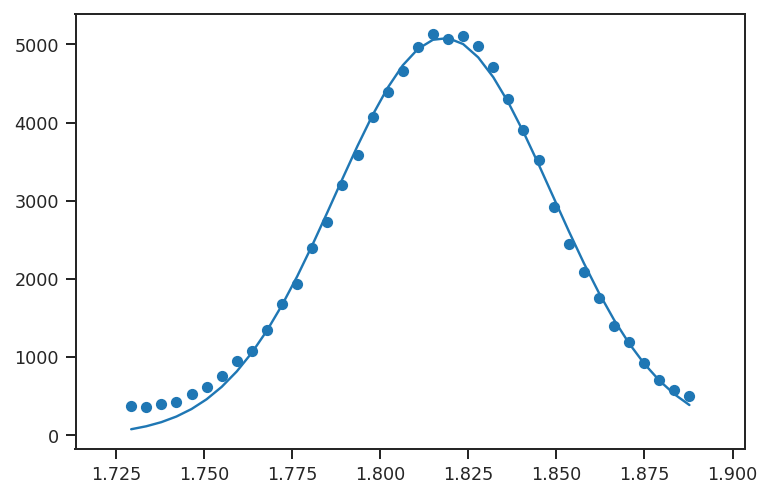

ratio:  2.4705380303960074


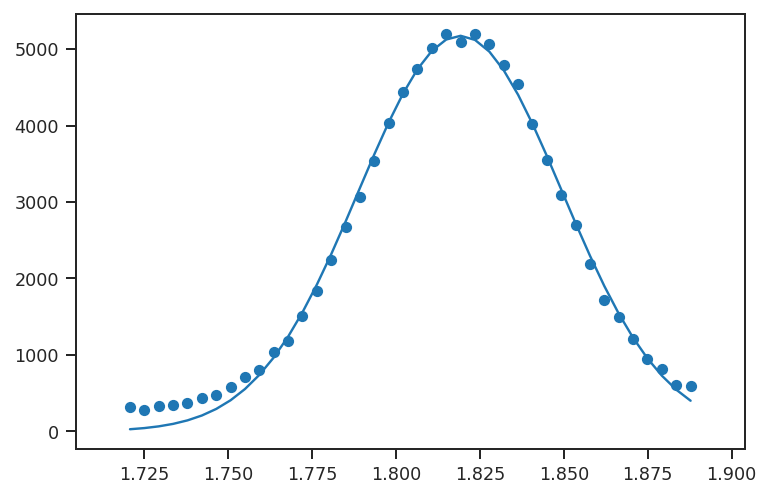

ratio:  2.514302357497404


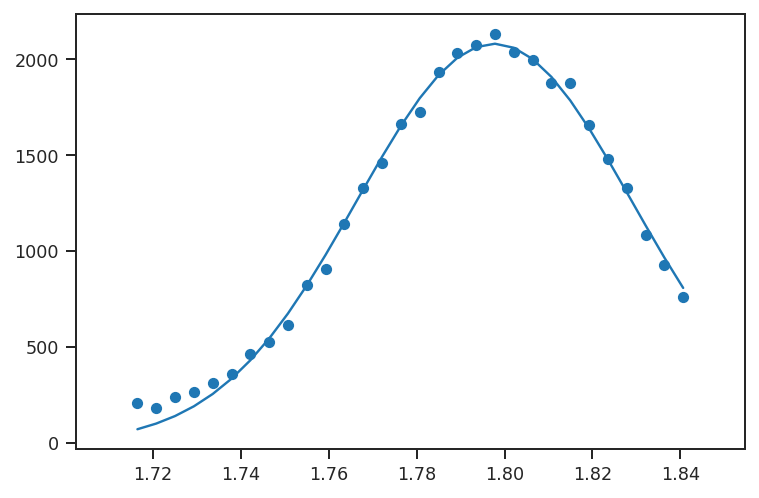

ratio:  1.011603424086525


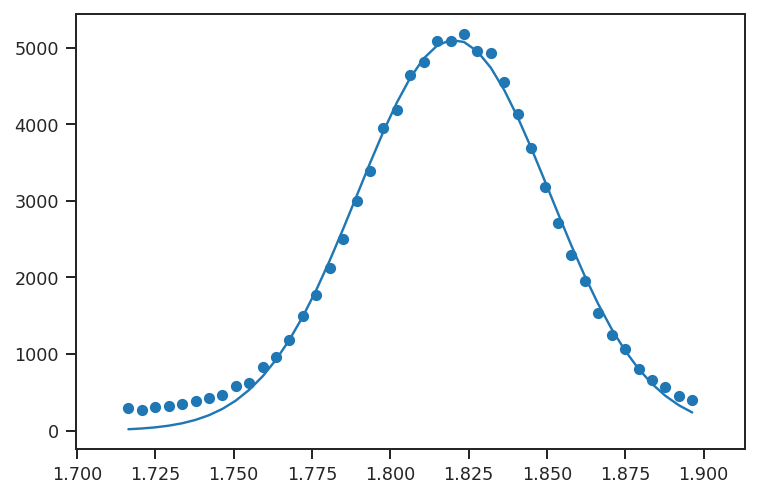

ratio:  2.4801692898555263


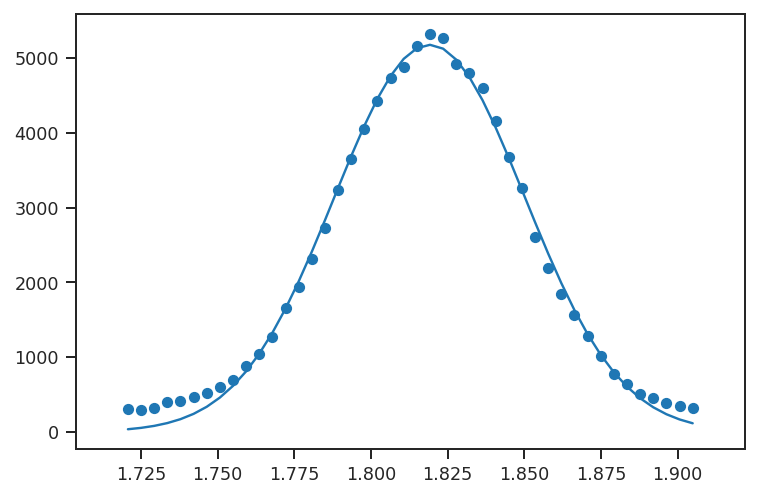

ratio:  2.5161844634556205


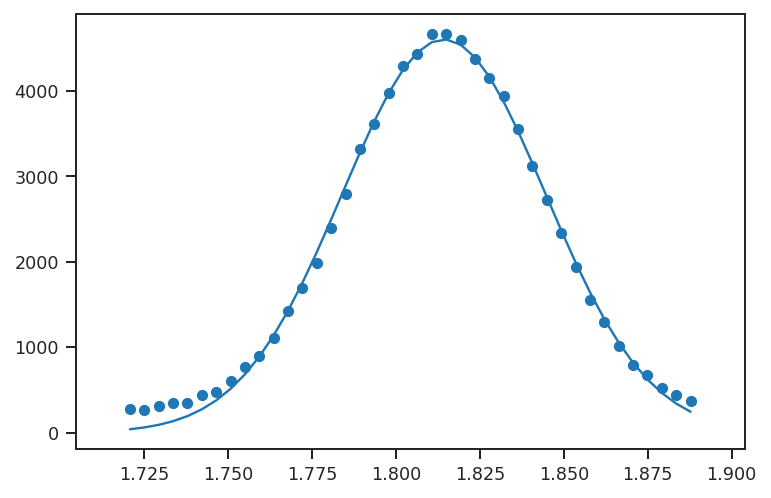

ratio:  2.236439307963823


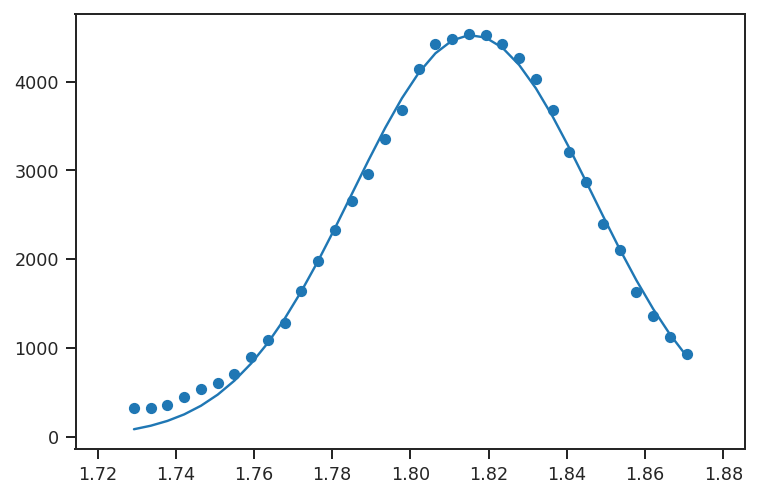

ratio:  2.199778194798842


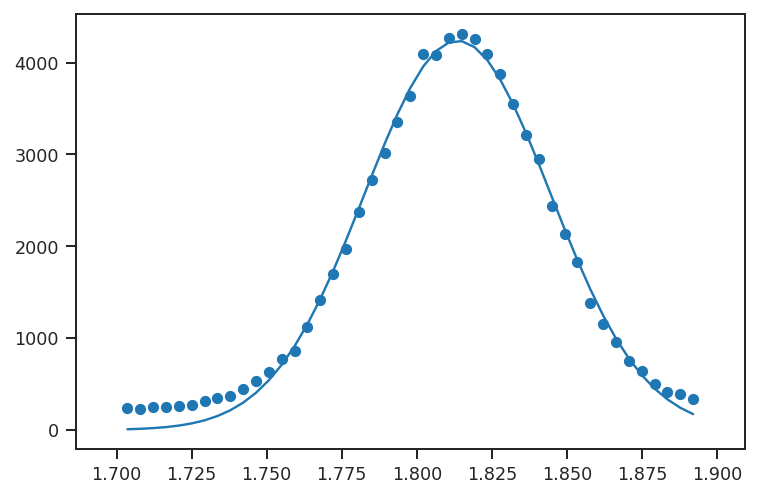

ratio:  2.059448043042834


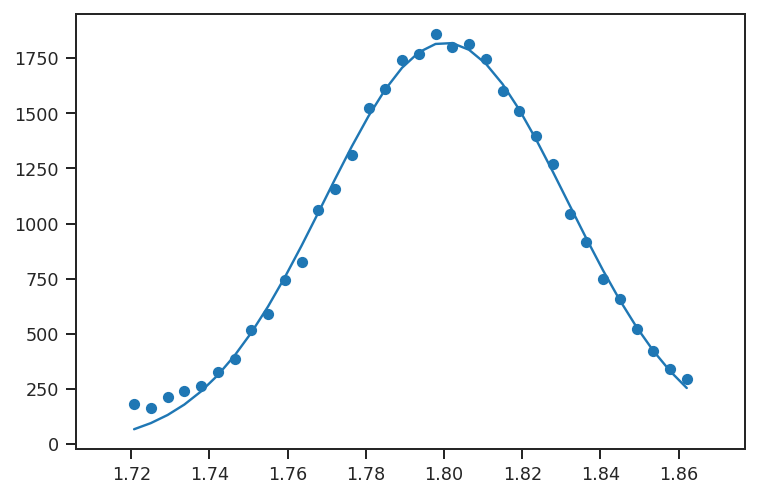

ratio:  0.884811739964233
dict_items([('Cu 0.75 +/- 0.01 mm', [1.3504082911392157, 0.053839999925772646]), ('Cu 0.75 +/- 0.02 mm', [1.3766261626369225, 0.06383618873850307]), ('Cu 15.25 +/- 0.01 mm', [0.0008471441360327212, 3.6376193813075564e-06]), ('Al 0.80 +/- 0.02 mm', [4.189699353716155, 0.18936637662353623]), ('Al 0.83 +/- 0.02 mm', [4.102359188678823, 0.18442404849160748]), ('Al 6.42 +/- 0.02 mm', [0.46262544772556025, 0.016461292925114973]), ('Pb 0.51 mm', [1.3631367962367402, 0.047818660183378034]), ('Pb 0.52 mm', [1.2251356780433678, 0.04114159336915086]), ('Pb 5.365 mm', [-0.020115415876838082, nan])])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


In [11]:
na_massAtten = {}
na_massAtten_vals = []
# Might need to hand pick indices for second peak


for key, value in na_values.items():
    #print(value[0][0][value[0][6]:value[0][7]], value[0][6], value[0][7])
    #plt.plot(value[0][0][value[0][6]:value[0][7]], value[0][1][value[0][6]:value[0][7]])
    
    par1, cov1 = fit_sources(value[0][0][value[0][4]:value[0][5]], value[0][1][value[0][4]:value[0][5]])
    #par2, cov2 = fit_sources(value[0][0][value[0][6]:value[0][7]], value[0][1][value[0][6]:value[0][7]])
    
    mac1 = massAtten(na1_noabso[0], par1[0], value[1][0], value[1][1])

    na_massAtten_vals.append(
        [mac1, massAtten_error(mac1, *na1_noabso, par1[0], np.sqrt(np.diag(cov1))[1], value[1][1], value[1][2])
         #mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])
        ])

na_massAtten = dict(zip(list(na_values.keys()), na_massAtten_vals))
print(na_massAtten.items())

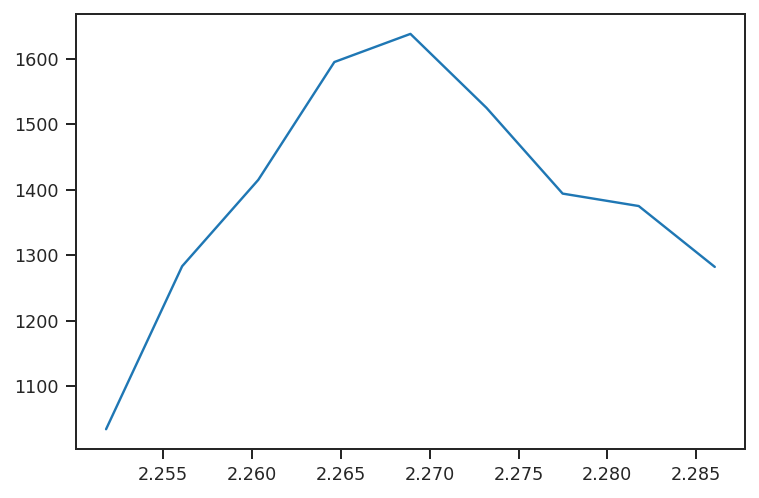

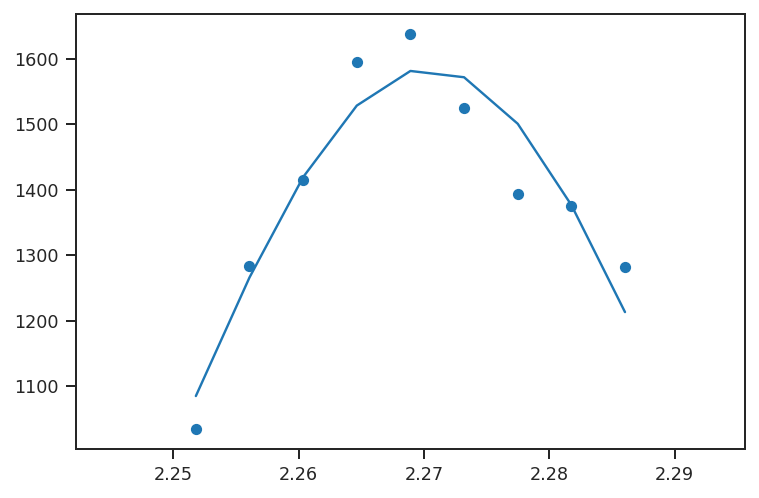

ratio:  2.896740872258115


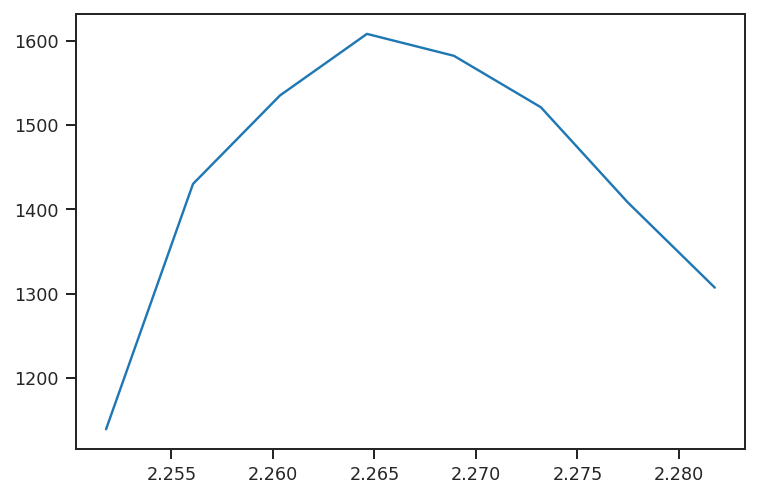

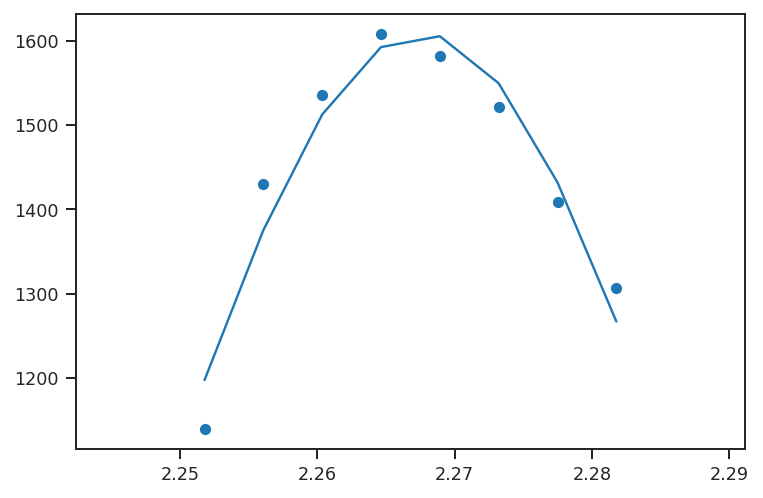

ratio:  2.9396658748311926


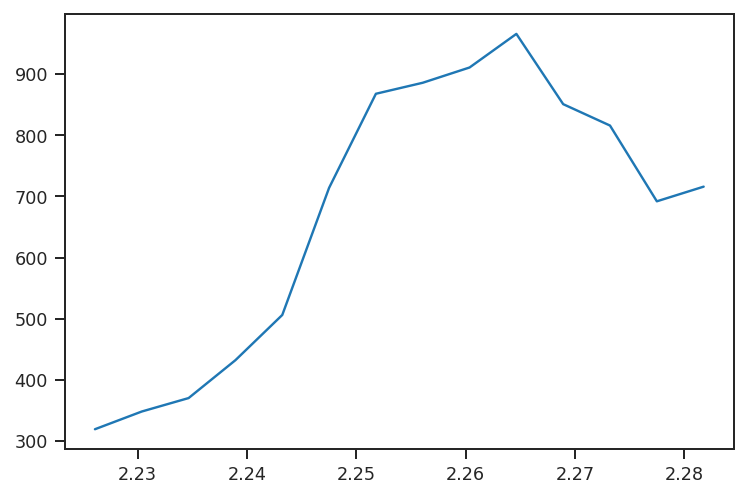

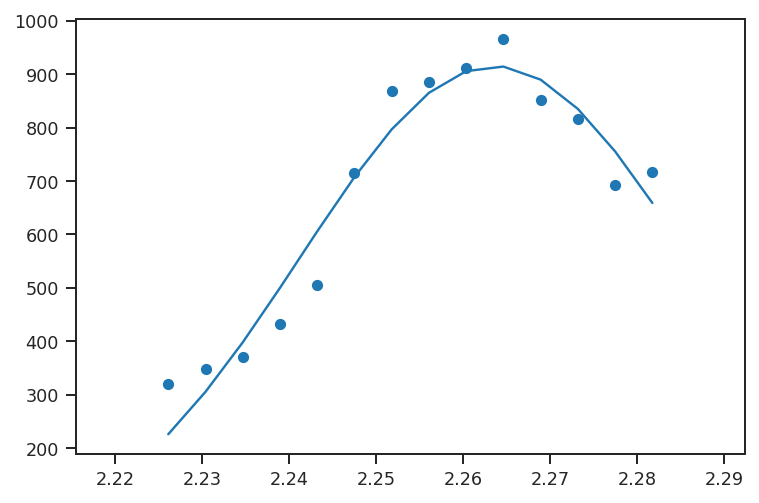

ratio:  1.6723112826866606


In [12]:
# Finding peaks manually for second peak of NA
# dict_keys(['Cu 0.75 +/- 0.01 mm', 'Cu 0.75 +/- 0.02 mm', 'Cu 15.25 +/- 0.01 mm'
# 'Al 0.80 +/- 0.02 mm', 'Al 0.83 +/- 0.02 mm', 'Al 6.42 +/- 0.02 mm', 
# 'Pb 0.51 mm', 'Pb 0.52 mm', 'Pb 5.365 mm'])

#----- Cu
na_massAtten_vals2 = []
value = na_values["Cu 0.75 +/- 0.01 mm"]
plt.plot(value[0][0][value[0][6]+3:value[0][7]-5], value[0][1][value[0][6]+3:value[0][7]-5])
par2, cov2 = fit_sources(value[0][0][value[0][6]+3:value[0][7]-5], value[0][1][value[0][6]+3:value[0][7]-5])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Cu 0.75 +/- 0.02 mm"]
plt.plot(value[0][0][value[0][6]+3:value[0][7]-5], value[0][1][value[0][6]+3:value[0][7]-5])
par2, cov2 = fit_sources(value[0][0][value[0][6]+3:value[0][7]-5], value[0][1][value[0][6]+3:value[0][7]-5])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Cu 15.25 +/- 0.01 mm"]
plt.plot(value[0][0][value[0][6]+8:value[0][7]-5], value[0][1][value[0][6]+8:value[0][7]-5])
par2, cov2 = fit_sources(value[0][0][value[0][6]+8:value[0][7]-5], value[0][1][value[0][6]+8:value[0][7]-5])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])


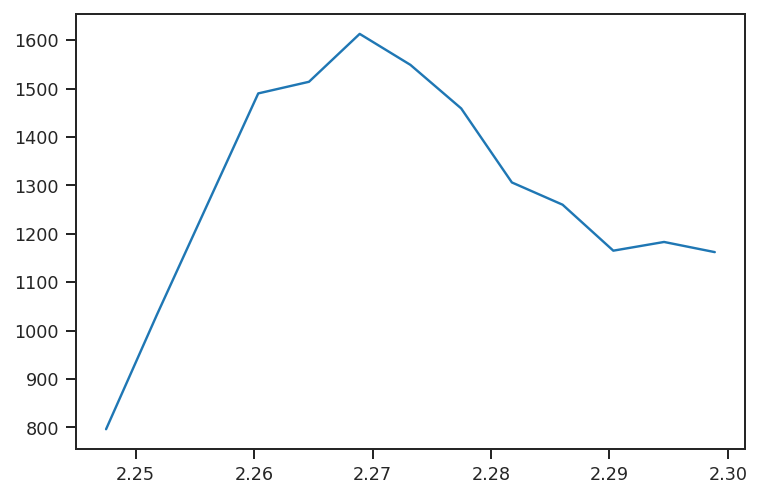

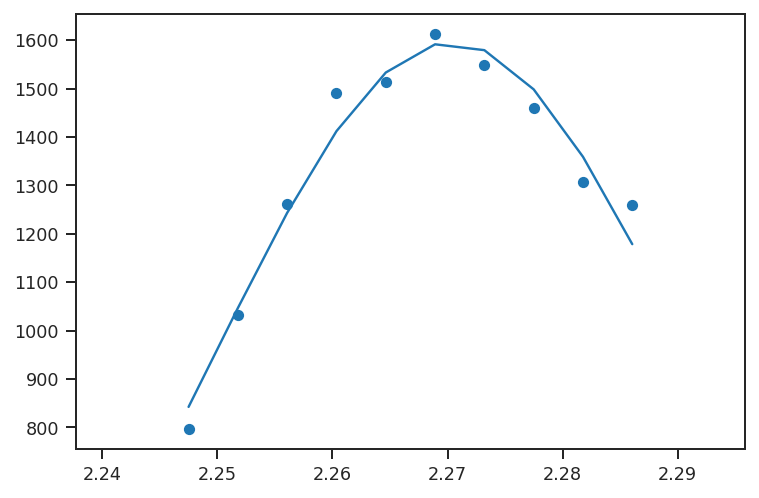

ratio:  2.9153378626473625


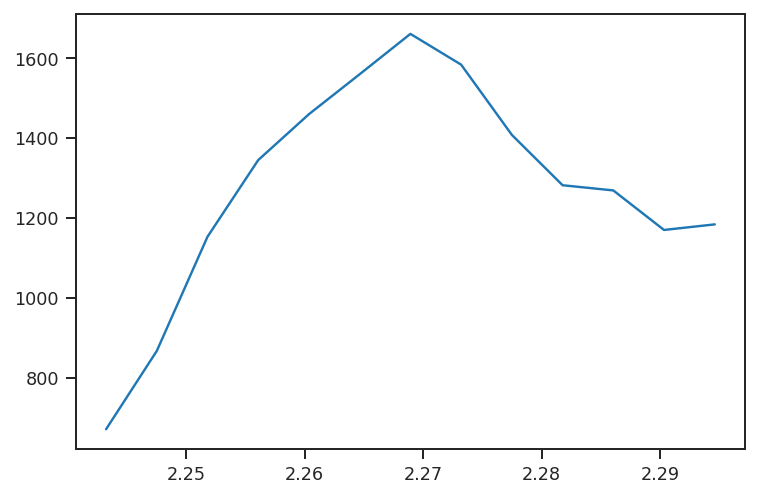

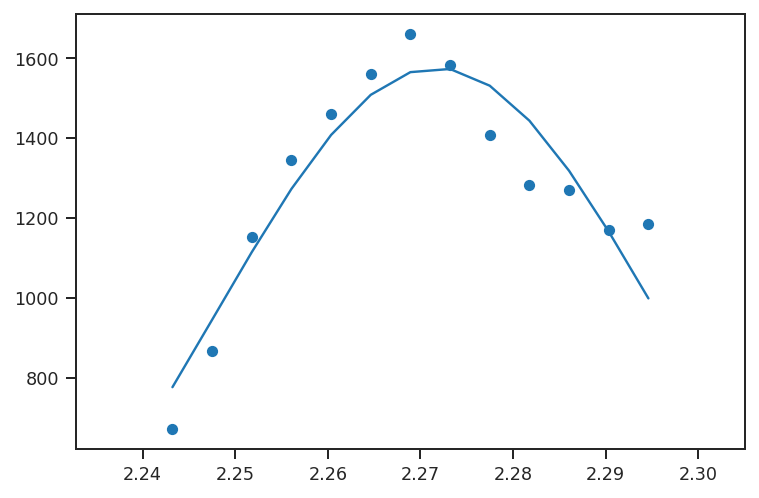

ratio:  2.880040585785524


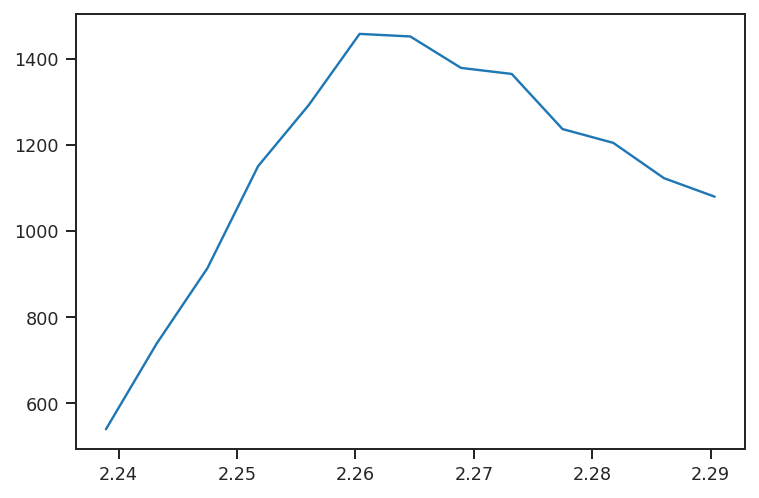

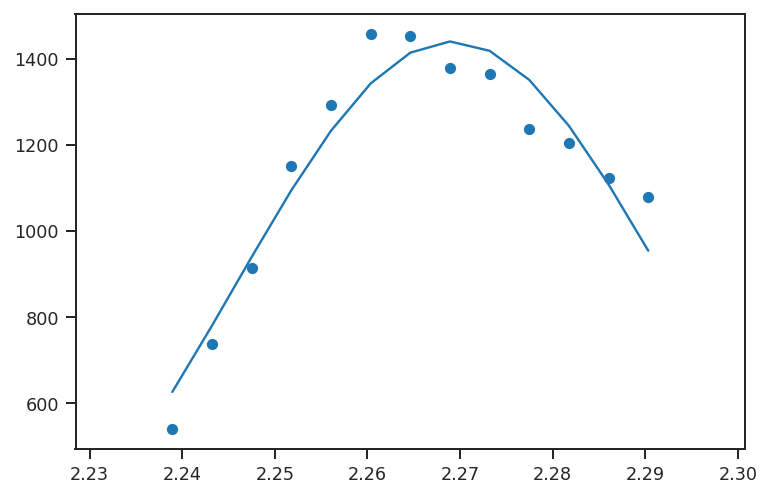

ratio:  2.632364281141502


In [13]:

#---- Al

value = na_values["Al 0.80 +/- 0.02 mm"]
plt.plot(value[0][0][value[0][6]:value[0][7]-2], value[0][1][value[0][6]:value[0][7]-2])
par2, cov2 = fit_sources(value[0][0][value[0][6]:value[0][7]-5], value[0][1][value[0][6]:value[0][7]-5])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Al 0.83 +/- 0.02 mm"]
plt.plot(value[0][0][value[0][6]-3:value[0][7]-3], value[0][1][value[0][6]-3:value[0][7]-3])
par2, cov2 = fit_sources(value[0][0][value[0][6]-3:value[0][7]-3], value[0][1][value[0][6]-3:value[0][7]-3])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Al 6.42 +/- 0.02 mm"]
plt.plot(value[0][0][value[0][6]:value[0][7]-2], value[0][1][value[0][6]:value[0][7]-2])
par2, cov2 = fit_sources(value[0][0][value[0][6]:value[0][7]-2], value[0][1][value[0][6]:value[0][7]-2])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])


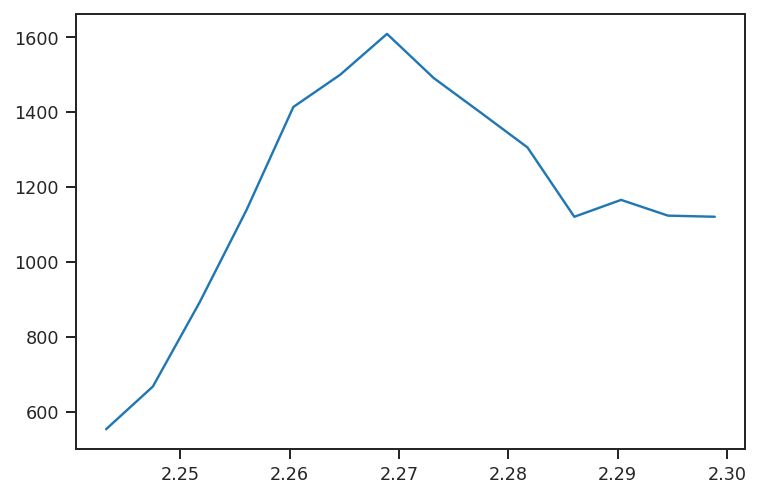

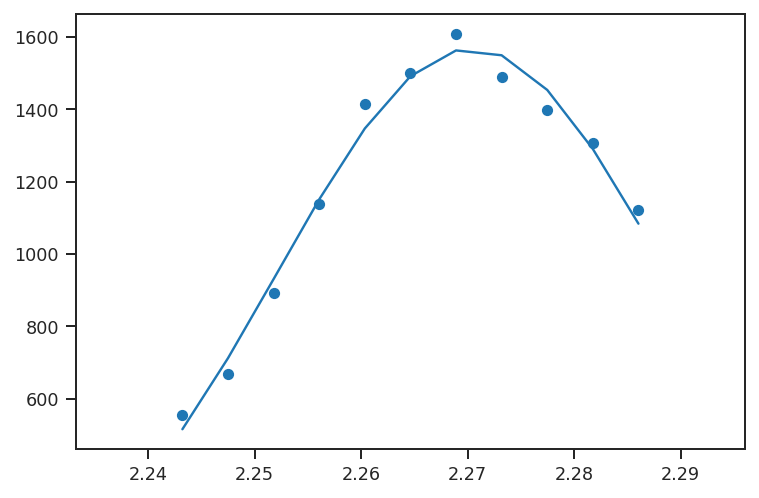

ratio:  2.866002148046641


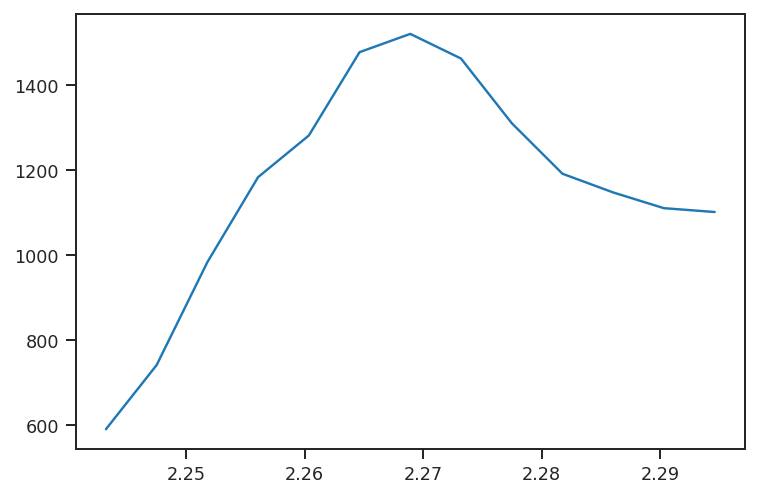

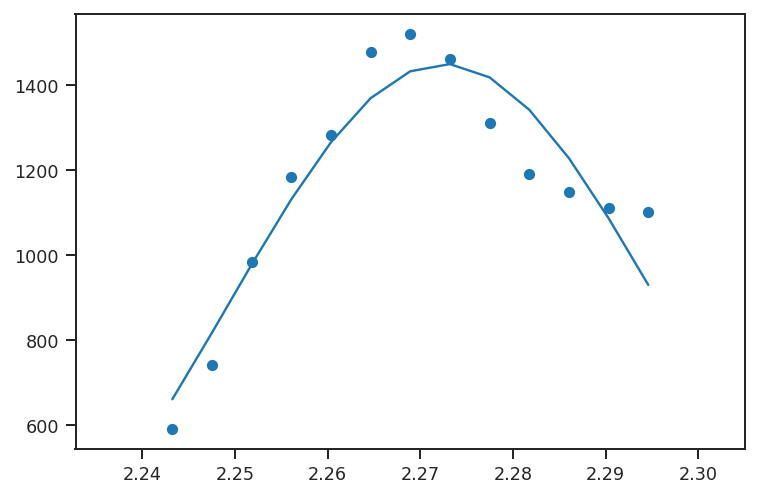

ratio:  2.6505625768026566


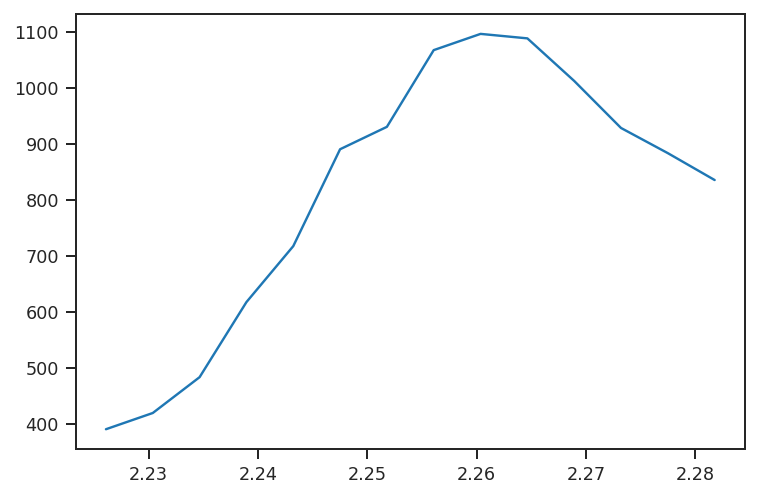

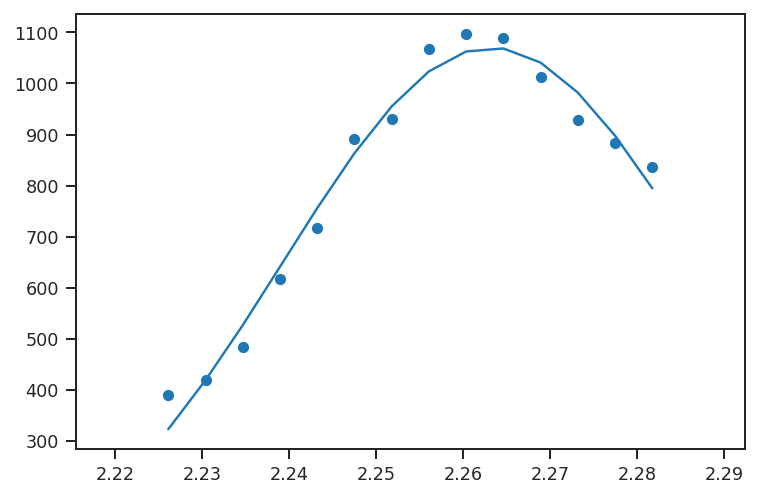

ratio:  1.9558561107651058


In [14]:
#---- 'Pb 0.51 mm', 'Pb 0.52 mm', 'Pb 5.365 mm'])

value = na_values["Pb 0.51 mm"]
plt.plot(value[0][0][value[0][6]+5:value[0][7]-2], value[0][1][value[0][6]+5:value[0][7]-2])
par2, cov2 = fit_sources(value[0][0][value[0][6]+5:value[0][7]-5], value[0][1][value[0][6]+5:value[0][7]-5])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Pb 0.52 mm"]
plt.plot(value[0][0][value[0][6]:value[0][7]-3], value[0][1][value[0][6]:value[0][7]-3])
par2, cov2 = fit_sources(value[0][0][value[0][6]:value[0][7]-3], value[0][1][value[0][6]:value[0][7]-3])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])

value = na_values["Pb 5.365 mm"]
plt.plot(value[0][0][value[0][6]+3:value[0][7]-4], value[0][1][value[0][6]+3:value[0][7]-4])
par2, cov2 = fit_sources(value[0][0][value[0][6]+3:value[0][7]-4], value[0][1][value[0][6]+3:value[0][7]-4])
mac2 = massAtten(na2_noabso[0], par2[0], value[1][0], value[1][1])
na_massAtten_vals2.append(
        [mac2, massAtten_error(mac2, *na2_noabso, par2[0], np.sqrt(np.diag(cov2))[1], value[1][1], value[1][2])])


In [15]:
na_massAtten2 = dict(zip(list(na_values.keys()), na_massAtten_vals2))
print(print(na_massAtten2.items()))
"""
Na values 1.
('Cu 0.75 +/- 0.01 mm', [1.3504082911392157, 0.053839999925772646]), 
('Cu 0.75 +/- 0.02 mm', [1.3766261626369225, 0.06383618873850307]), 
('Cu 15.25 +/- 0.01 mm', [0.0008471441360327212, 3.6376193813075564e-06]), 
('Al 0.80 +/- 0.02 mm', [4.189699353716155, 0.18936637662353623]), 
('Al 0.83 +/- 0.02 mm', [4.102359188678823, 0.18442404849160748]), 
('Al 6.42 +/- 0.02 mm', [0.46262544772556025, 0.016461292925114973]), 
('Pb 0.51 mm', [1.3631367962367402, 0.047818660183378034]), 
('Pb 0.52 mm', [1.2251356780433678, 0.04114159336915086]), 
('Pb 5.365 mm', [-0.020115415876838082, nan])])
"""
"""
Na Values 2.
('Cu 0.75 +/- 0.01 mm', [1.5880347411146596, 0.07429931975167757]),
('Cu 0.75 +/- 0.02 mm', [1.6099976511766536, 0.08443158376529376]), 
('Cu 15.25 +/- 0.01 mm', [0.03775864528775478, 0.001177679543191101]), 
('Al 0.80 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), 
('Al 0.83 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), 
('Al 6.42 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), 
('Pb 0.51 mm', [4.739281991566125, 0.24149210246464742]), 
('Pb 0.52 mm', [0.5662963321684946, 0.024507090893866865]), 
('Pb 5.365 mm', [4.935358477579818, 0.25398369947474997])])
None

"""


dict_items([('Cu 0.75 +/- 0.01 mm', [1.5880347411146596, 0.07429931975167757]), ('Cu 0.75 +/- 0.02 mm', [1.6099976511766536, 0.08443158376529376]), ('Cu 15.25 +/- 0.01 mm', [0.03775864528775478, 0.001177679543191101]), ('Al 0.80 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), ('Al 0.83 +/- 0.02 mm', [4.702815926444669, 0.23891713011153293]), ('Al 6.42 +/- 0.02 mm', [0.5563118072990574, 0.023862929102616292]), ('Pb 0.51 mm', [1.820586642629933, 0.08123710598678024]), ('Pb 0.52 mm', [1.653052351445208, 0.07097148899649795]), ('Pb 5.365 mm', [0.11026264456627569, 0.003927171238792976])])
None


"\nNa Values 2.\n('Cu 0.75 +/- 0.01 mm', [1.5880347411146596, 0.07429931975167757]),\n('Cu 0.75 +/- 0.02 mm', [1.6099976511766536, 0.08443158376529376]), \n('Cu 15.25 +/- 0.01 mm', [0.03775864528775478, 0.001177679543191101]), \n('Al 0.80 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), \n('Al 0.83 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), \n('Al 6.42 +/- 0.02 mm', [4.935358477579818, 0.25398369947474997]), \n('Pb 0.51 mm', [4.739281991566125, 0.24149210246464742]), \n('Pb 0.52 mm', [0.5662963321684946, 0.024507090893866865]), \n('Pb 5.365 mm', [4.935358477579818, 0.25398369947474997])])\nNone\n\n"

Expected mass atten for Cs137:

Name of material  | Density (g/cm3) |Linear mass absorption (cm-1)|Mass absorption coefficient (cm2/g)
------------------|------------------|----------------------------|-----------------------------
    Copper        |8.93              | 31.6936                    |3.549
    Aluminum      |2.71              |38.5077                     |14.206
    Lead          |11.34             | 7.7602                     |0.6831

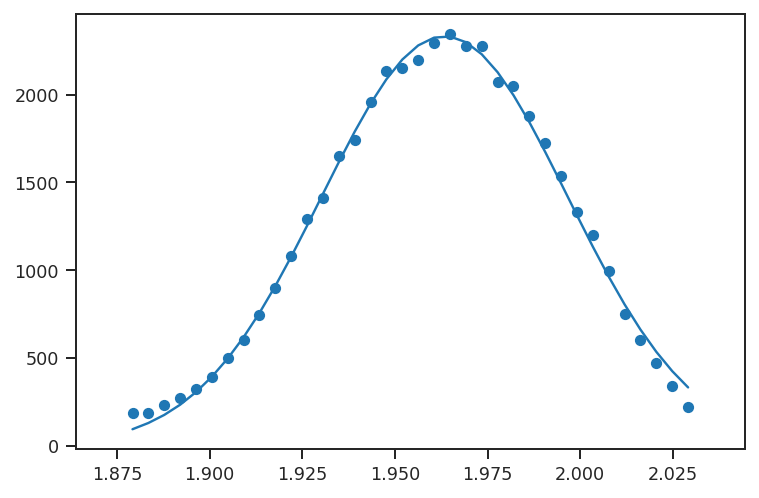

ratio:  1.1025961651687601


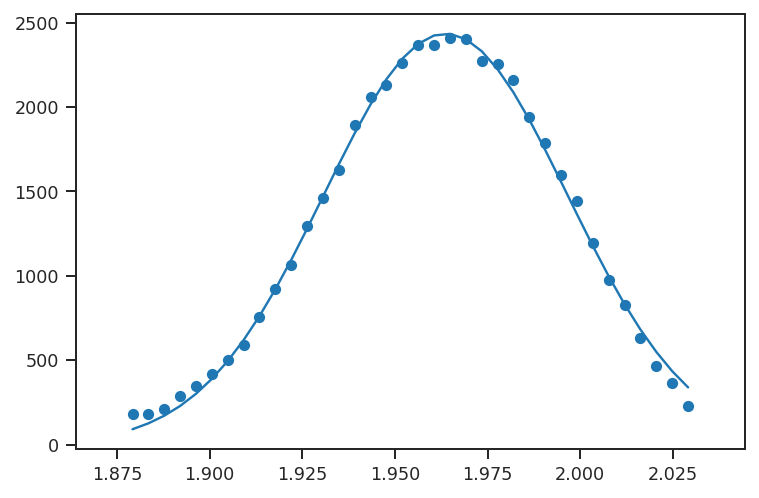

ratio:  1.1503486313516158


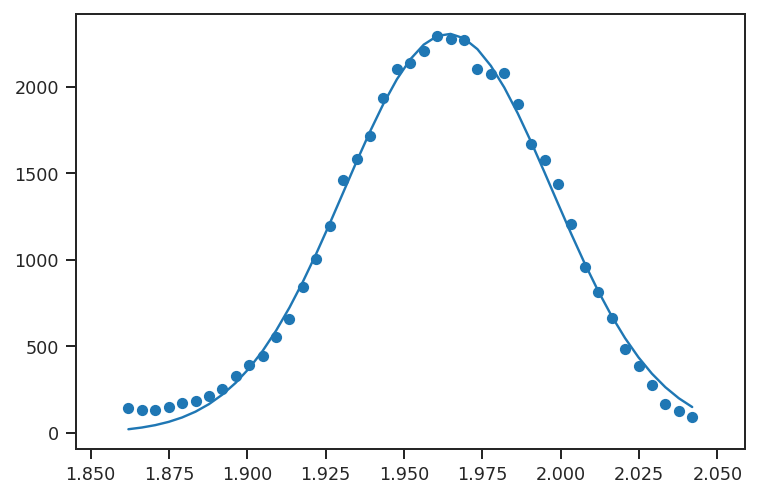

ratio:  1.090455118585441


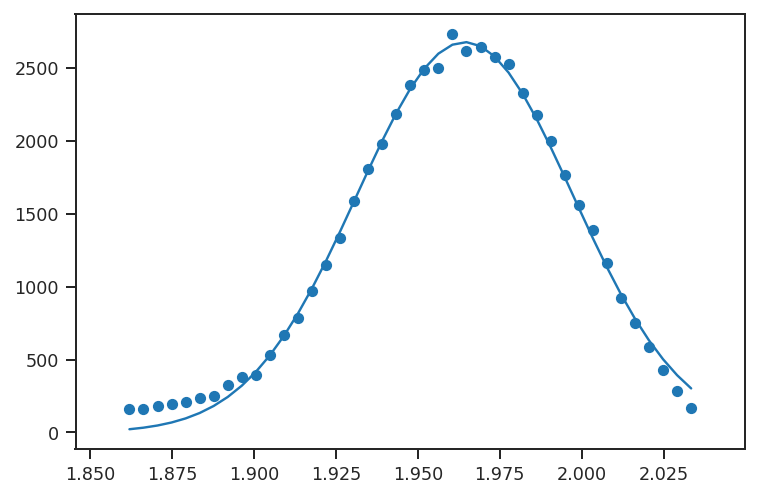

ratio:  1.2644708790713988


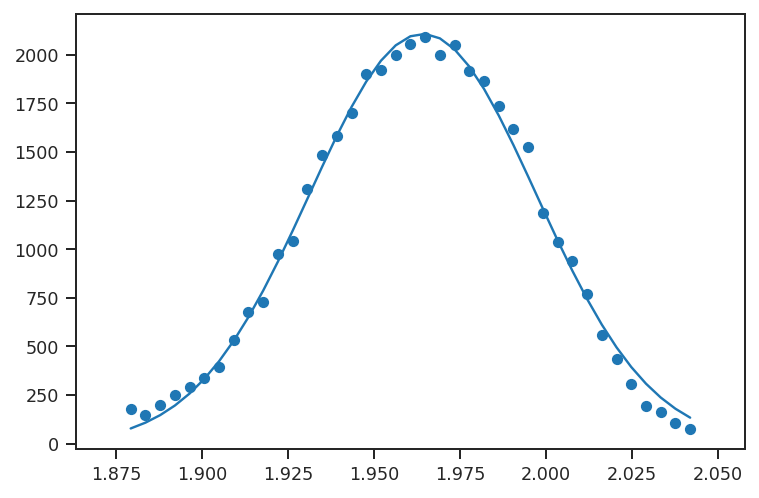

ratio:  0.99641070225202


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


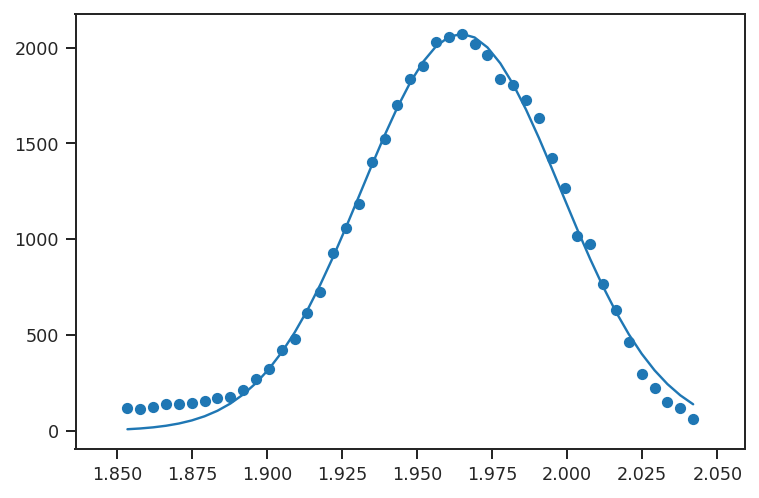

ratio:  0.9791197219814287


In [16]:
cs_massAtten = {}
cs_massAtten_vals = []

def exp(x, m):
    return np.exp(m*x)

ratio = []
tickness = []

for key, value in cs_values.items():
    """
    cs_massAtten_vals.append(
        [massAtten(cs_no_abso[2], value[0][2], value[1][0], value[1][1])])
    """

    par1, cov1 = fit_sources(value[0][0][value[0][4]:value[0][5]], value[0][1][value[0][4]:value[0][5]])
    
    mac1 = massAtten(cs1_noabso[0], par1[0], value[1][0], value[1][1])
    cs_massAtten_vals.append(
         np.array([mac1, 
                   massAtten_error(mac1, *cs1_noabso, par1[0], np.sqrt(np.diag(cov1))[1], value[1][1], value[1][2])]))

cs_massAtten = dict(zip(list(cs_values.keys()), cs_massAtten_vals))

In [17]:
"""

    ratio +=[cs1_noabso[0]/ par1[0]];
    tickness += [value[1][1]]
#     mac1 = massAtten(,, value[1][0], )
par, cov =  fitter.curve_fit(exp,tickness,ratio)
plt.scatter(tickness,ratio)
xval = np.linspace(0,7,2000)

"""

'\n\n    ratio +=[cs1_noabso[0]/ par1[0]];\n    tickness += [value[1][1]]\n#     mac1 = massAtten(,, value[1][0], )\npar, cov =  fitter.curve_fit(exp,tickness,ratio)\nplt.scatter(tickness,ratio)\nxval = np.linspace(0,7,2000)\n\n'

In [18]:
print(cs_massAtten.items())

dict_items([('Cu 0.75 +/- 0.01 mm', array([0.14582687, 0.00264602])), ('Cu 0.75 +/- 0.02 mm', array([0.20913035, 0.00637186])), ('Al 0.80 +/- 0.02 mm', array([0.39942412, 0.01100622])), ('Al 0.83 +/- 0.02 mm', array([1.04323015, 0.03206184])), ('Pb 0.51 mm', array([-0.00621737,         nan])), ('Pb 0.52 mm', array([-0.03578442,         nan]))])


In [19]:
print(
"""
\n[('Cu 0.75 +/- 0.01 mm', [1.6189713293912857, 0.07108770728518422]), 
\n('Cu 0.75 +/- 0.02 mm', [1.682274746576407, 0.0846125532966995]), 
\n('Al 0.80 +/- 0.02 mm', [4.950339673387202, 0.24035304365981003]), 
\n('Al 0.83 +/- 0.02 mm', [5.42965454929442, 0.27428315878579274]), 
\n('Pb 0.51 mm', [1.6997662350244134, 0.0677116551724728]), 
\n('Pb 0.52 mm', [1.6373920789405898, 0.06464400062631348])]
""")



[('Cu 0.75 +/- 0.01 mm', [1.6189713293912857, 0.07108770728518422]), 

('Cu 0.75 +/- 0.02 mm', [1.682274746576407, 0.0846125532966995]), 

('Al 0.80 +/- 0.02 mm', [4.950339673387202, 0.24035304365981003]), 

('Al 0.83 +/- 0.02 mm', [5.42965454929442, 0.27428315878579274]), 

('Pb 0.51 mm', [1.6997662350244134, 0.0677116551724728]), 

('Pb 0.52 mm', [1.6373920789405898, 0.06464400062631348])]



## Averaging MAC

In [30]:
def avg_mac(coefs):
    avg = np.mean(coefs, axis=0)
    error = np.sqrt(sum(np.array(coefs[:,1])**2))/len(coefs)
    print(len(coefs))
    return avg, error

In [31]:
cs_massAtten_vals = np.array(cs_massAtten_vals)
display(cs_massAtten_vals)

array([[ 0.14582687,  0.00264602],
       [ 0.20913035,  0.00637186],
       [ 0.39942412,  0.01100622],
       [ 1.04323015,  0.03206184],
       [-0.00621737,         nan],
       [-0.03578442,         nan]])

In [32]:
cs_cu = cs_massAtten_vals[:2]
avg_mac(cs_cu)

2


(array([0.17747861, 0.00450894]), 0.0034497099207212683)

In [33]:
cs_al = cs_massAtten_vals[2:4]
avg_mac(cs_al)

2


(array([0.72132713, 0.02153403]), 0.016949174604554824)

In [34]:
cs_pb = cs_massAtten_vals[4:]
avg_mac(cs_pb)

2


(array([-0.02100089,         nan]), nan)

In [35]:
na_massAtten_vals = np.array(na_massAtten_vals)
display(na_massAtten_vals)
na_massAtten_vals2 = np.array(na_massAtten_vals2)
display(na_massAtten_vals2)

array([[ 1.35040829e+00,  5.38399999e-02],
       [ 1.37662616e+00,  6.38361887e-02],
       [ 8.47144136e-04,  3.63761938e-06],
       [ 4.18969935e+00,  1.89366377e-01],
       [ 4.10235919e+00,  1.84424048e-01],
       [ 4.62625448e-01,  1.64612929e-02],
       [ 1.36313680e+00,  4.78186602e-02],
       [ 1.22513568e+00,  4.11415934e-02],
       [-2.01154159e-02,             nan]])

array([[1.58803474e+00, 7.42993198e-02],
       [1.60999765e+00, 8.44315838e-02],
       [3.77586453e-02, 1.17767954e-03],
       [4.93535848e+00, 2.53983699e-01],
       [4.70281593e+00, 2.38917130e-01],
       [5.56311807e-01, 2.38629291e-02],
       [1.82058664e+00, 8.12371060e-02],
       [1.65305235e+00, 7.09714890e-02],
       [1.10262645e-01, 3.92717124e-03]])

In [40]:
na_cu = na_massAtten_vals[:3]
na_cu2 = na_massAtten_vals2[:3]
avg_mac(np.concatenate((na_cu, na_cu2), axis=0))

6


(array([0.99394544, 0.04626473]), 0.02334777694609248)

In [41]:
na_al = na_massAtten_vals[3:6]
na_al2 = na_massAtten_vals2[3:6]
avg_mac(np.concatenate((na_al, na_al2), axis=0))

6


(array([3.15819503, 0.15116925]), 0.07308696921159065)

In [44]:
na_pb = na_massAtten_vals[6:-1]
na_pb2 = na_massAtten_vals2[6:]
avg_mac(np.concatenate((na_pb, na_pb2), axis=0))

5


(array([1.23443482, 0.0490192 ]), 0.02500487734831918)